In [3]:
%matplotlib inline

In [55]:
from __future__ import absolute_import, division
from matplotlib import pyplot as plt
import gluoncv
from gluoncv import model_zoo, data, utils
import cv2
from IPython import display
import random
import mxnet as mx

In [5]:
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained=True)

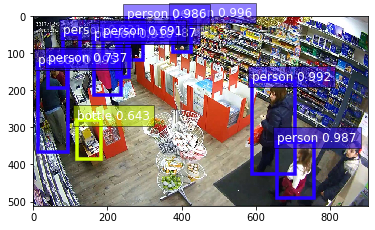

In [197]:
cap = cv2.VideoCapture('./retail_store/RetailStore.mp4')
#cap = cv2.VideoCapture('./RightExport.mp4')
count = 0
success = True
x = 0
while success and count < 10:
    success,image = cap.read()
    if count % 30 == 0:
        display.clear_output(wait=True)
        bitmap = "frame%d.jpg" % (count//30)
        cv2.imwrite(bitmap, image)
        x, img = data.transforms.presets.rcnn.load_test(bitmap, short=512)
        box_ids, scores, bboxes = net(x)
        ax = utils.viz.plot_bbox(img, bboxes[0], scores[0], box_ids[0], class_names=net.classes)
        bitmap2 = 'frame%d-box.jpg' % (count//30)
        plt.savefig(bitmap2, dpi=300)
        plt.show()
    count += 1

In [195]:
cap = cv2.VideoCapture('./RightExport.mp4')
count = 0
success = True
x = 0
with open('det.txt', 'w') as f:
    while success and count < 625*5+1 :
        success,image = cap.read()
        if count % 5 == 0:
            display.clear_output(wait=True)
            bitmap = "%d.jpg" % (count//30)
            cv2.imwrite(bitmap, image)
            x, img = data.transforms.presets.rcnn.load_test(bitmap, short=512)
            box_ids, scores, bboxes = net(x)
            class_names = net.classes
            bb_left, bb_top, width, height, conf = faster_rcnn_to_mot(img, bboxes[0], scores[0], box_ids[0], thresh=0.5, class_names=net.classes)
            f.write("%d,%d,%d,%d,%d,%d,%4f\n" % (count//30, -1, bb_left, bb_top, width, height, round(float(conf),4)))
        count += 1

In [148]:
def faster_rcnn_to_mot(img, bboxes, scores=None, labels=None, thresh=0.5, class_names=None):
    
    if labels is not None and not len(bboxes) == len(labels):
        raise ValueError('The length of labels and bboxes mismatch, {} vs {}'
                         .format(len(labels), len(bboxes)))
    if scores is not None and not len(bboxes) == len(scores):
        raise ValueError('The length of scores and bboxes mismatch, {} vs {}'
                         .format(len(scores), len(bboxes)))
    if isinstance(bboxes, mx.nd.NDArray):
        bboxes = bboxes.asnumpy()
    if isinstance(labels, mx.nd.NDArray):
        labels = labels.asnumpy()
    if isinstance(scores, mx.nd.NDArray):
        scores = scores.asnumpy()

    for i, bbox in enumerate(bboxes):
        if scores is not None and scores.flat[i] < thresh:
            continue
        if labels is not None and labels.flat[i] < 0:
            continue
        cls_id = int(labels.flat[i]) if labels is not None else -1
        if class_names is not None and cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = str(cls_id) if cls_id >= 0 else ''
        if class_name == 'person':
            xmin, ymin, xmax, ymax = [int(x) for x in bbox]
            score = '{:.3f}'.format(scores.flat[i]) if scores is not None else ''
            bb_left = xmin
            bb_top = ymax
            bb_width = xmax - xmin
            bb_height = ymax - ymin
            conf = score
    return bb_left, bb_top, bb_width, bb_height, conf